# El dataset se puede descargar de: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset

Una vez descargado se debe poner en la carpeta /kaggle/input/musicnet-dataset todo el contenido de la descarga

_______________________________

Para la ejecucipn de este cuaderno se deben instalar las siguientes librerias (en las versiones establecidas), tal como se muestra a continuacion

# 1) Preprocesar datos

In [1]:
import numpy as np

from libraries.Kaggle_audios import Kaggle_audios
from libraries.ProcessAudio import ProcessAudio

import pickle

In [2]:
TIEMPO_SELECCIONADO = 3
ARCHIVO_FINAL_TRAIN = "data/scaler_pca_to_use/train"
ARCHIVO_FINAL_TEST = "data/scaler_pca_to_use/test"

In [3]:
from functools import wraps
from time import time


def count_elapsed_time(f):
    @wraps(f)
    def cronometro(*args, **kwargs):
        t_inicial = time()  # tomo la hora antes de ejecutar la funcion
        salida = f(*args, **kwargs)
        t_final = time()  # tomo la hora despues de ejecutar la funcion
        print('Tiempo transcurrido (en segundos): {}'.format(t_final - t_inicial))
        return salida

    return cronometro

In [4]:
def prepare_data_tensorflow(data):
    train = data[:, 1:-11]
    instrument_list = data[:,-11:]
    X = np.array(train, dtype=float)
    y = instrument_list
    return X, y

def aplicando_pca(scaler_pca, name_file, dataX, dataY):
    x_for_model = scaler_pca.transform(X=dataX)
    # print("Original", X.shape)
    np.savez_compressed(name_file + ".npz", data=x_for_model)
    np.savez_compressed(name_file + "_label.npz", data=dataY)
    
def leyendo_datos(name_file):
    x = np.load(name_file + ".npz")['data']
    y = np.load(name_file + "_label.npz")['data']
    return x, y

def Preprocesar_audios(name_file, use_train, save:bool = True):
    cortar = Kaggle_audios(config_time=TIEMPO_SELECCIONADO, train=use_train)

    print("\tLeyendo todos los archivos WAV originales")
    all_data, all_label, rate = cortar.read_data(
        limit=None, show_info=False)  # leer todos los wav y cada uno separarlos en pequeños audios de 3 segundos

    print("\tTime:", TIEMPO_SELECCIONADO, " - Input:", all_data.shape, " - Output:", all_label.shape, " - rate:", rate)

    print("\tExtrayendo caracteristicas audios")
    data = list()
    for id_audio, x in enumerate(all_data):
        processAudio = ProcessAudio()
        processAudio.set_data(x)
        data_save = processAudio.get_all(id_audio)  # Extrayendo caracteristicas audios, salen 26 caracteristicas
        data_save += all_label[id_audio].tolist()

        data.append(data_save)
        try:
            if id_audio%150 == 0:
                print("\n\t", end="")
            print(".", end="")
        except:
            print()

    print("\tConvirtiendo a numpy")
    data = np.array(data)

    if save:
        print("\tGuardando data")
        np.savez_compressed(name_file + '.npz', data)
        print("\tGuardando csv completo")

    return data

## 1.1) Leer audios, separarlos en audios mas pequeños y extraer las caracteristicas de cada uno de estos nuevos audios

In [5]:
print("Preprocesando TRAIN")
data_train = Preprocesar_audios(ARCHIVO_FINAL_TRAIN, use_train=True, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Train:", len(data_train))

Preprocesando TRAIN
/kaggle/input/musicnet-dataset/musicnet/musicnet/train_data/
/kaggle/input/musicnet-dataset/musicnet/musicnet/train_labels/
	Leyendo todos los archivos WAV originales

	. . . . 

KeyboardInterrupt: 

## 1.2) Hallando el normalizador y el PCA

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [7]:
X_train, _ = prepare_data_tensorflow(data_train)
scaler_pca = make_pipeline(StandardScaler(), PCA())
scaler_pca.fit(X_train)

modelo_pca = scaler_pca.named_steps['pca']

In [7]:
import matplotlib.pyplot as plt
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.plot(
    np.arange(26) + 1,
    prop_varianza_acum,
    marker='o'
)

for x, y in zip(np.arange(26) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=20
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

ax.axvline(x=15, color="red")
ax.axhline(y=0.925, color="red")

plt.show()


NameError: name 'modelo_pca' is not defined

In [9]:
"""
            Hallando el Normalizador y el PCA (92%)
"""

MINIMA_VARIANA_EXPLICADA = 0.92
scaler_pca = make_pipeline(StandardScaler(), PCA(MINIMA_VARIANA_EXPLICADA))
scaler_pca.fit(X_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.92))])

In [10]:
pickle.dump(scaler_pca, open('data/scaler_pca_to_use/scaler_pca.pkl','wb'))

## 1.3) Aplicando el normalizador, PCA a los datos train y guardando el resultado

In [11]:
"""
            Aplicando PCA
"""
X_train, Y_train = prepare_data_tensorflow(data_train)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TRAIN, X_train, Y_train )

## 1.4) Aplicando el normalizador, PCA a los datos test y guardando el resultado

In [12]:
print("Preprocesando TEST")
data_test = Preprocesar_audios(ARCHIVO_FINAL_TEST, False, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Test:", len(data_test))

X_test, Y_test = prepare_data_tensorflow(data_test)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TEST, X_test, Y_test )

Preprocesando TEST
/kaggle/input/musicnet-dataset/musicnet/musicnet/test_data/
/kaggle/input/musicnet-dataset/musicnet/musicnet/test_labels/
	Leyendo todos los archivos WAV originales

	. . . . . . . . . . 	Time: 3  - Input: (499, 132300)  - Output: (499, 11)  - rate: 44100
	Extrayendo caracteristicas audios

	............................................................................................................................

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


..........................
	......................................................................................................................................................
	......................................................................................................................................................
	.................................................	Convirtiendo a numpy
	Time: 3  - Test: 499


# 2) Cargando los datos para usarlos en el entrenamiento del modelo

In [13]:
"""
            Leyendo datos
"""
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
print("x_for_model_charge_train:", xTrain_for_model_charge.shape, yTrain.shape)

x_for_model_charge_train: (40625, 15) (40625, 11)


In [14]:
xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
print("x_for_model_charge_test:", xTest_for_model_charge.shape, yTest.shape)

x_for_model_charge_test: (499, 15) (499, 11)


# 3) Creando y entrenando modelos modelos

## 3.1) Modelo clasico

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [20]:
mean = lambda lst: int((sum(lst) / len(lst))*100)/100


def calcular_porcentajes_aciertos(y_f, y_t):
    verdaderos = dict()
    falsos = dict()
    for j in range(y_f.shape[1]):
        verdaderos[j] = 0
        falsos[j] = 0

    for i in range(y_f.shape[0]):
        for j in range(y_f.shape[1]):
            if y_f[i][j] == y_t[i][j]:
                verdaderos[j] += 1
            else:
                falsos[j] += 1

    for j in range(y_f.shape[1]):
        #y_final.shape[1] -> 100%
        #verdaderos[j]    -> X
        verdaderos[j] = int(verdaderos[j] * 100 / y_f.shape[0])
        falsos[j] = int(falsos[j] * 100 / y_f.shape[0])

    return verdaderos, falsos, str(mean([v for i, v in verdaderos.items()])) + "%"

## 3.1.1)  Dividiendo datos para train y valid

In [21]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

## 3.2) Entrenando modelo

In [22]:
algoritmo_clasico = RandomForestClassifier()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_




y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[RandomForestClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[RandomForestClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[RandomForestClassifier] Aciertos test", aciertos)

[RandomForestClassifier] Aciertos train 100.0%
[RandomForestClassifier] Aciertos validacion 95.9%
[RandomForestClassifier] Aciertos test 94.81%


In [24]:
from sklearn.tree import export_graphviz
export_graphviz(algoritmo_clasico,
                filled=True,
                rounded=True)

AttributeError: 'MultiOutputClassifier' object has no attribute 'tree_'

In [20]:
algoritmo_clasico = LogisticRegression(
          solver='sag', #'liblinear', 'sag'
          max_iter=1000, 
          random_state=1, #0 ,1
          multi_class='ovr'
          )
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[LogisticRegression] Aciertos train", aciertos)




y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[LogisticRegression] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[LogisticRegression] Aciertos test", aciertos)

[LogisticRegression] Aciertos train 92.63%
[LogisticRegression] Aciertos validacion 92.36%
[LogisticRegression] Aciertos test 91.18%


In [21]:
algoritmo_clasico = DecisionTreeClassifier(
          max_depth = None,
          min_samples_split = 2,
          min_samples_leaf  = 1,
          random_state      = 123
          )
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[DecisionTreeClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[DecisionTreeClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[DecisionTreeClassifier] Aciertos test", aciertos)

[DecisionTreeClassifier] Aciertos train 100.0%
[DecisionTreeClassifier] Aciertos validacion 92.9%
[DecisionTreeClassifier] Aciertos test 92.9%


In [22]:
algoritmo_clasico = DummyClassifier()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[DummyClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[DummyClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[DummyClassifier] Aciertos test", aciertos)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/

[DummyClassifier] Aciertos train 85.18%
[DummyClassifier] Aciertos validacion 85.27%
[DummyClassifier] Aciertos test 80.9%


In [23]:
algoritmo_clasico = KNeighborsClassifier(11)
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[KNeighborsClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[KNeighborsClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[KNeighborsClassifier] Aciertos test", aciertos)

[KNeighborsClassifier] Aciertos train 97.09%
[KNeighborsClassifier] Aciertos validacion 96.36%
[KNeighborsClassifier] Aciertos test 96.09%


In [24]:
algoritmo_clasico = GaussianNB()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[GaussianNB] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[GaussianNB] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[GaussianNB] Aciertos test", aciertos)

[GaussianNB] Aciertos train 90.72%
[GaussianNB] Aciertos validacion 90.54%
[GaussianNB] Aciertos test 89.36%


## 3.3) Guardando modelo

In [25]:
pickle.dump(algoritmo_clasico, open('data/scaler_pca_to_use/KNeighborsClassifier.pkl', 'wb'))

## 3.4) Cargando modelo

In [26]:
#model = pickle.load(open('data/scaler_pca_to_use/KNeighborsClassifier.pkl', 'rb'))
model = pickle.load(open('data/scaler_pca_to_use/randomforest.pkl', 'rb'))

## 3.5) Probando modelo

In [27]:
y_final = model.predict(X_train)

aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Aciertos train 94.9%


## 3.3) Validando modelo

In [28]:
y_final = model.predict(X_test)

aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Aciertos validacion 94.9%


## 3.4) Testeando modelo

In [29]:
@count_elapsed_time
def predecir():
    y_final = model.predict(xTest_for_model_charge)
    return y_final

y_final = predecir()
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.8659086227416992
Aciertos test 93.18%


# 4) Creando y entrenando modelo red neuronal

In [5]:
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
yTrain = np.array(yTrain, dtype=float)
xTrain_for_model_charge = np.array(xTrain_for_model_charge, dtype=float)
print("datos train:", xTrain_for_model_charge.shape, yTrain.shape)

xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
yTest = np.array(yTest, dtype=float)
xTest_for_model_charge = np.array(xTest_for_model_charge, dtype=float)
print("datos test:", xTest_for_model_charge.shape, yTest.shape)

datos train: (40625, 15) (40625, 11)
datos test: (499, 15) (499, 11)


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, LeakyReLU, Conv1D, Conv2D, Flatten, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, InputLayer, Reshape, Activation, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, UpSampling1D, UpSampling2D, MaxPooling1D

In [7]:
from tensorflow.keras.optimizers import Adam
def get_optimizador():
    adam = Adam(learning_rate=1e-5)
    return adam

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, RemoteMonitor, TerminateOnNaN, BackupAndRestore

def get_callbacks(name="model"):
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar
    early_stop = EarlyStopping(
        monitor='accuracy',
        patience=8, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar).
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        restore_best_weights=True,
        mode='max')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='loss', 
        factor=0.1, 
        patience=5, 
        min_delta=1e-4, 
        mode='min',
        verbose=1,
    )

    # Saves Keras model after each epoch
    #Para algunos casos es importante saber cual entrenamiento fue mejor, 
    #este callback guarda el modelo tras cada epoca completada con el fin de si luego se desea un registro de pesos para cada epoca
    #Se ha usado este callback para poder optener el mejor modelo de pesos, sobretodo en la red neuronal creada desde cero
    #siendo de gran utilidad para determinar el como ir modificando los layer hasta obtener el mejor modelo
    checkpointer = ModelCheckpoint(
        filepath='models_backup/' + name +'-{val_accuracy:.4f}.h5', 
        monitor='val_accuracy',
        verbose=1, 
        mode='max',
        save_best_only=True,
        save_weights_only=False
    )

    remote_monitor = RemoteMonitor(
        root='http://localhost:6006',
        path='/publish/epoch/end/',
        field='data',
        headers=None,
        send_as_json=False
    )
    
    backup_restore = BackupAndRestore(backup_dir="backup")
    
    proteccion_nan_loss = TerminateOnNaN()

    
    callbacks_list = [early_stop, reduce_lr, checkpointer, proteccion_nan_loss, backup_restore]#, remote_monitor]
    
    return callbacks_list

In [9]:
import matplotlib.pyplot as plt
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 4.1) Modelo basico

In [10]:
cantidad_entradas = 15
cantidad_salidas = 11

model = Sequential(name="RedBasica")
model.add(Dense(32, activation='relu', input_shape=(cantidad_entradas,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(cantidad_salidas, activation='softmax', name='output_layer'))

model.summary()

Model: "RedBasica"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0 

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.save("model.h5")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [36]:
model.compile(optimizer=get_optimizador(),
              loss='mse',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)

Epoch 1/500
567/572 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.1979
Epoch 1: val_accuracy improved from -inf to 0.50800, saving model to models_backup/model-0.5080.h5
572/572 [==============================] - 3s 3ms/step - loss: 0.1435 - accuracy: 0.1992 - val_loss: 0.1379 - val_accuracy: 0.5080 - lr: 1.0000e-05
Epoch 2/500
556/572 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.4542
Epoch 2: val_accuracy improved from 0.50800 to 0.57224, saving model to models_backup/model-0.5722.h5
572/572 [==============================] - 1s 2ms/step - loss: 0.1275 - accuracy: 0.4560 - val_loss: 0.1127 - val_accuracy: 0.5722 - lr: 1.0000e-05
Epoch 3/500
558/572 [============================>.] - ETA: 0s - loss: 0.1141 - accuracy: 0.5389
Epoch 3: val_accuracy improved from 0.57224 to 0.67192, saving model to models_backup/model-0.6719.h5
572/572 [==============================] - 1s 2ms/step - loss: 0.1139 - accuracy: 0.5395 - val_loss: 0.1002 - 

Epoch 27/500
550/572 [===========================>..] - ETA: 0s - loss: 0.0819 - accuracy: 0.7004
Epoch 27: val_accuracy did not improve from 0.75880
572/572 [==============================] - 1s 2ms/step - loss: 0.0820 - accuracy: 0.7004 - val_loss: 0.0795 - val_accuracy: 0.7529 - lr: 1.0000e-05
Epoch 28/500
568/572 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.7035
Epoch 28: val_accuracy improved from 0.75880 to 0.75978, saving model to models_backup/model-0.7598.h5
572/572 [==============================] - 1s 2ms/step - loss: 0.0813 - accuracy: 0.7034 - val_loss: 0.0791 - val_accuracy: 0.7598 - lr: 1.0000e-05
Epoch 29/500
568/572 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.7007
Epoch 29: val_accuracy improved from 0.75978 to 0.76815, saving model to models_backup/model-0.7682.h5
572/572 [==============================] - 1s 2ms/step - loss: 0.0809 - accuracy: 0.7012 - val_loss: 0.0789 - val_accuracy: 0.7682 - lr: 1.0000e-05
Epoc

571/572 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.7419
Epoch 80: val_accuracy did not improve from 0.79449
572/572 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.7419 - val_loss: 0.0716 - val_accuracy: 0.7581 - lr: 1.0000e-05
Epoch 81/500
556/572 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.7407
Epoch 81: val_accuracy did not improve from 0.79449
572/572 [==============================] - 1s 2ms/step - loss: 0.0709 - accuracy: 0.7403 - val_loss: 0.0715 - val_accuracy: 0.7770 - lr: 1.0000e-05
Epoch 82/500
571/572 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.7382
Epoch 82: val_accuracy did not improve from 0.79449
572/572 [==============================] - 1s 2ms/step - loss: 0.0709 - accuracy: 0.7382 - val_loss: 0.0715 - val_accuracy: 0.7844 - lr: 1.0000e-05
Epoch 83/500
554/572 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.7382
Epoch 83: val_accurac

Epoch 134/500
568/572 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.7767
Epoch 134: val_accuracy did not improve from 0.80605
572/572 [==============================] - 1s 2ms/step - loss: 0.0682 - accuracy: 0.7768 - val_loss: 0.0699 - val_accuracy: 0.8024 - lr: 1.0000e-05
Epoch 135/500
571/572 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.7764
Epoch 135: val_accuracy did not improve from 0.80605
572/572 [==============================] - 1s 2ms/step - loss: 0.0682 - accuracy: 0.7764 - val_loss: 0.0699 - val_accuracy: 0.8031 - lr: 1.0000e-05
Epoch 136/500
560/572 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.7766
Epoch 136: val_accuracy did not improve from 0.80605
572/572 [==============================] - 1s 2ms/step - loss: 0.0682 - accuracy: 0.7767 - val_loss: 0.0698 - val_accuracy: 0.8014 - lr: 1.0000e-05
Epoch 137/500
549/572 [===========================>..] - ETA: 0s - loss: 0.0681 - accuracy: 0.7776
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


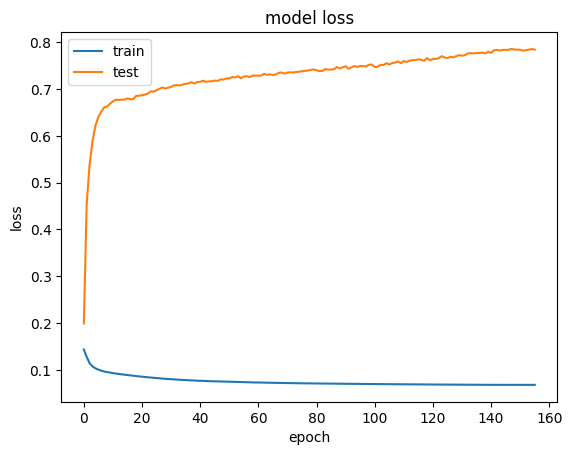

In [38]:
plot_history(history)

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Evaluate train acc: ', test_acc)

127/127 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.8041
Evaluate train acc:  0.8040856719017029


In [40]:
@count_elapsed_time
def predecir(d):
    y_final = model.predict(d)
    y_final = np.round(y_final, 0).astype(int)
    return y_final

In [41]:
y_final = predecir(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Tiempo transcurrido (en segundos): 0.9034075736999512
Aciertos train 88.36%


In [42]:
y_final = predecir(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Tiempo transcurrido (en segundos): 0.1325826644897461
Aciertos validacion 87.72%


In [43]:
y_final = predecir(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.0647740364074707
Aciertos test 87.54%


# 4.2) Modelo RNA medio

In [13]:
def modelo_simple(cantidad_entradas, cantidad_salidas):
    model = Sequential(name="Redsimple")  # los nombres van sin espacios
    model.add(Dense(8 * 4, activation="relu",  input_shape=(cantidad_entradas,)) ) 
    model.add(Dense(16*4, activation='relu'))
    model.add(Dense(16*8, activation='relu'))
    model.add(Dense(32*8, activation='relu'))
    model.add(Reshape((32, 8)))

    model.add(UpSampling1D(size=3))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(8, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dense(24, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation='relu'))

    model.add(GlobalAveragePooling1D())

    model.add(Flatten())

    model.add(Dense(cantidad_salidas, activation="softmax", name='output_layer'))

    return model

In [14]:
cantidad_entradas = 15
cantidad_salidas = 11

model = modelo_simple(cantidad_entradas, cantidad_salidas)

model.summary()

Model: "Redsimple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                512       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 reshape (Reshape)           (None, 32, 8)             0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 96, 8)            0         
 )                                                               
                                                         

In [15]:
model.compile(optimizer=get_optimizador(),
              loss='mean_squared_error',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [16]:
model.save("model_experimental.h5")

In [47]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

In [48]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)



Epoch 1/500
572/572 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.6240
Epoch 1: val_accuracy improved from -inf to 0.66478, saving model to models_backup/model-0.6648.h5
572/572 [==============================] - 11s 11ms/step - loss: 0.1463 - accuracy: 0.6240 - val_loss: 0.1427 - val_accuracy: 0.6648 - lr: 1.0000e-05
Epoch 2/500
569/572 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.6650
Epoch 2: val_accuracy did not improve from 0.66478
572/572 [==============================] - 5s 9ms/step - loss: 0.1188 - accuracy: 0.6649 - val_loss: 0.1139 - val_accuracy: 0.6648 - lr: 1.0000e-05
Epoch 3/500
570/572 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.6649
Epoch 3: val_accuracy did not improve from 0.66478
572/572 [==============================] - 5s 9ms/step - loss: 0.1112 - accuracy: 0.6649 - val_loss: 0.1109 - val_accuracy: 0.6648 - lr: 1.0000e-05
Epoch 4/500
570/572 [============================>.] - ETA: 0s

567/572 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.7994
Epoch 28: val_accuracy did not improve from 0.77307
572/572 [==============================] - 5s 9ms/step - loss: 0.0802 - accuracy: 0.7992 - val_loss: 0.0841 - val_accuracy: 0.7069 - lr: 1.0000e-05
Epoch 29/500
571/572 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.7995
Epoch 29: val_accuracy did not improve from 0.77307
572/572 [==============================] - 5s 9ms/step - loss: 0.0800 - accuracy: 0.7995 - val_loss: 0.0833 - val_accuracy: 0.7074 - lr: 1.0000e-05
Epoch 30/500
567/572 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.7905
Epoch 30: val_accuracy did not improve from 0.77307
572/572 [==============================] - 5s 9ms/step - loss: 0.0797 - accuracy: 0.7904 - val_loss: 0.0835 - val_accuracy: 0.5661 - lr: 1.0000e-05
Epoch 31/500
567/572 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.7642
Epoch 31: val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


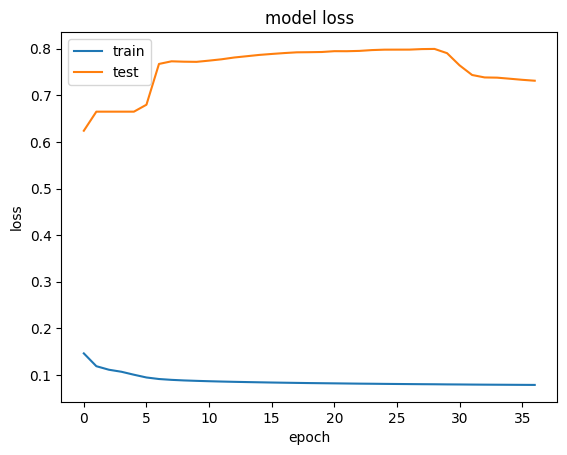

In [49]:
plot_history(history)

In [50]:
#test_loss, test_acc = model.evaluate(X_test, y_test)
#print('Evaluate train acc: ', test_acc)

In [51]:
y_final = predecir(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Tiempo transcurrido (en segundos): 3.888659715652466
Aciertos train 86.72%


In [52]:
y_final = predecir(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Tiempo transcurrido (en segundos): 0.43511319160461426
Aciertos validacion 86.72%


In [53]:
y_final = predecir(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.3243682384490967
Aciertos test 86.0%


# Bibliografia usada